# Bikes theft model project

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive/")
    %cd "/content/gdrive/MyDrive/IMT Atlantique/Data Science/Project Bycicle/bikes-theft-model"

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go

#import branca, geopandas, folium
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import ipywidgets
import matplotlib.pyplot as plt

Mounted at /content/gdrive/
/content/gdrive/MyDrive/IMT Atlantique/Data Science/Project Bycicle/bikes-theft-model


## Geographical data location

In this section we will present some statistics graphically according to their geopositional position, found in the database.

In [ ]:
''' Important functions '''
# Read data & geomap with respect to city
def read_data_map(data_path, geo_path, city = None):
    skip_cols = ['City']
    
    # Read data of Toronto an Ottawa cities
    canada_data = pd.read_csv(data_path, dtype = {"GeoUID":str})
    if "GeoUID" in canada_data.columns:
        canada_data["GeoUID"] = canada_data["GeoUID"].apply(lambda x: x if len(x.split(".")[-1]) > 1 else x + "0") # Fix important bug
    if city is not None:
        canada_data = canada_data[canada_data["City"] == city].drop(columns = skip_cols)
    
    if "%Theft/sqKm" in canada_data.columns:
        canada_data["%Theft/sqKm"] = canada_data["%Theft/sqKm"].replace({np.inf:0}) * 100
    if "%PopulationBike" in canada_data.columns:
        canada_data["%PopulationBike"] = canada_data["%PopulationBike"].replace({np.inf:0}) * 100
    
    # Read maps information
    canada_map = geopandas.read_file(geo_path, driver = "GeoJSON").rename(columns = {"id":"GeoUID"})
    canada_map["GeoUID"] = canada_map["GeoUID"].apply(lambda x: x if len(x.split(".")[-1]) > 1 else x + "0") # Fix important bug
    return canada_data, canada_map

# Update pandas to geopandas
def to_geo(df):
    try:
        df_point = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.x, df.y)).set_crs("EPSG:4326")
    except:
        df_point = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.Long, df.Lat)).set_crs("EPSG:4326")
    return df_point

# Join geopandas with data with two possibles cases (with column or with points in polygon)
def mapJoinTable(df_point, df_map, how = "right", keep_geo_cols = False, print_info = True):
    if "GeoUID" in df_point:
        df_point["GeoUID"] = df_point["GeoUID"].astype(str); df_map["GeoUID"] = df_map["GeoUID"].astype(str)
        how = "left" if how == "right" else "right" if how == "left" else how # Change how method
        df_result = df_map.join(df_point.set_index("GeoUID"), how = how, on = "GeoUID")#.rename(columns = {"id":"GeoUID"})
    else:
        df_point = to_geo(df_point)
        df_result = geopandas.tools.sjoin(df_point, df_map, how = how)
    if not keep_geo_cols: df_result = df_result.drop(columns = df_map.columns.drop(["GeoUID","geometry"]))
    if print_info:
        print("[INFO] Map, unique GeoUID and merge data lenght, respectively:",len(df_map), len(df_result["GeoUID"].unique()), len(df_result))
        print("[INFO] Total data not-merge successfully:", len(df_result[df_result["geometry"].isnull()]))        
    return df_result.reset_index(drop=True)

# Plot a single map
def plotMap(df_geomap, value_var, caption = "Cost of bike by region", zoom_start = 10,
            name = 'Canada maps', fields2show = None, aliases = None, index = True):
    df_data_geomap = df_geomap.copy().fillna(0) 
    
    # Map creation colors
    min_cn, max_cn = df_data_geomap[value_var].quantile([0.01,0.99]).apply(round, 2)
    index = df_data_geomap[value_var].quantile([0.2,0.4,0.6,0.8]) if index else None
    colormap = branca.colormap.LinearColormap(
        colors=['white','yellow','orange','red','darkred'], vmin=min_cn, vmax=max_cn, index = index
    )
    colormap.caption = caption
    
    # Geo map skeleton
    init_local = [z[0] for z in df_data_geomap.iloc[0]["geometry"].centroid.xy][::-1]
    geomap = folium.Map(location = init_local, zoom_start=zoom_start, tiles="OpenStreetMap")

    style_function = lambda x: {
        'fillColor': colormap(x['properties'][value_var]),
        'color': 'black', 'weight':2, 'fillOpacity':0.5
    }
    
    if fields2show is None: fields2show = list(df_data_geomap.columns.drop("geometry"))
    if aliases is None: aliases = fields2show.copy()
    stategeo = folium.GeoJson(df_data_geomap.to_json(), name=name, style_function = style_function,
        tooltip = folium.GeoJsonTooltip(fields = fields2show, aliases = aliases, localize=True)
    ).add_to(geomap)

    colormap.add_to(geomap)
    return geomap

### Data Merge
In this section, we describe how mix the theft-bikes-data into geomap position. We start reading the data and show them in geographical zone.

In [ ]:
### Toronto
save, year = False, None
df, df_geomap = read_data_map("./Data/Bicycle_Thefts_Toronto.csv", "./Data/Maps/pop_toronto.geojson")
if save:
    df_new2 = mapJoinTable(df, df_geomap, "left")
    print(len(df_new2), len(df_new2[df_new2["GeoUID"].isnull()]), len(df_new2[df_new2["GeoUID"].notnull()]))
    df_new2[df_new2["GeoUID"].notnull()].drop(columns = "geometry").to_csv("./Data/Bicycle_Thefts_Toronto_geo.csv", index = False)
df_new2 = mapJoinTable(df, df_geomap, "right")
# display(df_new2, df_new2.columns)

# Geomap proof 
status = list(df_new2["Status"].unique())
df_new2["new_status"] = df_new2["Status"].apply(lambda x: status.index(x) + 1 if x == x else 0)
if year is not None: df_new2 = df_new2[df_new2["Occurrence_Year"] == year]
toro = plotMap(df_new2.groupby("GeoUID").head(1), value_var = "new_status", 
            caption = "Status", name = 'Canada maps', index=False,fields2show = ["Status"])

### Ottawa
df, df_geomap = read_data_map("./Data/Bicycle_Theft_Ottawa.csv", "./Data/Maps/pop_ottawa.geojson")
if save:
    df_new2 = mapJoinTable(df, df_geomap, "left")
    print(len(df_new2), len(df_new2[df_new2["GeoUID"].isnull()]), len(df_new2[df_new2["GeoUID"].notnull()]))
    df_new2[df_new2["GeoUID"].notnull()].drop(columns = "geometry").to_csv("./Data/Bicycle_Theft_Ottawa_geo.csv", index = False)
df_new2 = mapJoinTable(df, df_geomap, "right")
# display(df_new2, df_new2.columns)

# Geomap proof 
status = list(df_new2["Bicycle_Status"].unique())
df_new2["new_status"] = df_new2["Bicycle_Status"].apply(lambda x: status.index(x) + 1 if x == x else 0)
if year is not None: df_new2 = df_new2[df_new2["Report_Date"].str.contains(str(year))]
otaw = plotMap(df_new2.groupby("GeoUID").head(1), value_var = "new_status", 
            caption = "Bicycle_Status", name = 'Canada maps', index=False)

# Show map
toro
# otaw

[INFO] Map, unique GeoUID and merge data lenght, respectively: 572 572 21589
[INFO] Total data not-merge successfully: 0
[INFO] Map, unique GeoUID and merge data lenght, respectively: 188 188 5652
[INFO] Total data not-merge successfully: 0


### Geojson incorporation

Now, let's trying to plot a geojson file and function to join data with map.

In order to be able to plot the geographical maps of Toronto and Ottawa, the function of `plotMap` was defined, which plots the map of the filtered city and a specific time. To facilitate the process, functions were defined to make the reading of the data and the maps (`read_data_map`), as well as a function to correlate the geopositional information with their respective information (`mapJoinTable`). 

To understand better the use of the functions, let's see a simple example of how to use them. Let's take the city of Toronto as an example. To do this, let's take the city of Toronto as an example and filter it by the hour with the highest records of theft. Finally, let's join the two tables and see what happens.

In [ ]:
# Read geojson/data and put in pandas dataframe
toronto_data, toronto_map = read_data_map(data_path = "./Data/Stolen_bikes_johan_2016.csv", 
                                        geo_path = "./Data/Maps/pop_toronto.geojson", 
                                        city = "Toronto")

toronto_data_geomap = mapJoinTable(toronto_data, toronto_map, how = "right")
# display(toronto_data_geomap.head().append(toronto_data_geomap.tail()), toronto_data_geomap.shape, toronto_data_geomap.columns)

# For demo
max_hour = toronto_data_geomap.groupby("Hour").size().idxmax()
toronto_data_demo = toronto_data_geomap[toronto_data_geomap["Hour"] == max_hour].copy() # Important data = Demo
display(toronto_data_demo.head().append(toronto_data_demo.tail()), toronto_data_demo.shape, toronto_data_demo.columns)

[INFO] Map, unique GeoUID and merge data lenght, respectively: 572 572 2209
[INFO] Total data not-merge successfully: 0


GeoUID                                           geometry  \
16    5350164.00  MULTIPOLYGON (((-79.43183 43.68881, -79.43125 ...   
49    5350071.00  MULTIPOLYGON (((-79.35029 43.67130, -79.35278 ...   
64    5350010.02  MULTIPOLYGON (((-79.41122 43.64012, -79.41318 ...   
75    5350010.01  MULTIPOLYGON (((-79.41122 43.64012, -79.41459 ...   
90    5350075.00  MULTIPOLYGON (((-79.32966 43.67494, -79.33095 ...   
2135  5350073.00  MULTIPOLYGON (((-79.34227 43.66775, -79.34188 ...   
2143  5350074.00  MULTIPOLYGON (((-79.32801 43.67092, -79.32966 ...   
2162  5350052.00  MULTIPOLYGON (((-79.44384 43.65086, -79.44532 ...   
2182  5350196.02  MULTIPOLYGON (((-79.36929 43.71167, -79.36892 ...   
2204  5350063.06  MULTIPOLYGON (((-79.38309 43.66137, -79.38504 ...   

      Unnamed: 0  Hour  PopulationCT  BicycleT  Area(sqKm)  SumThBikes  \
16        2181.0  12.0        6258.0     195.0     0.62823         1.0   
49        1694.0  12.0        3481.0     185.0     0.46398         4.0   
64         842.0  12.0        7740.0     370.0     0.54735         4.0   
75         823.0  12.0        5428.0     225.0     0.26263         2.0   
90        1730.0  12.0        4083.0     125.0     0.49858         2.0   
2135      1712.0  12.0        2605.0      80.0     0.35718         1.0   
2143      1720.0  12.0        3848.0     205.0     0.39980         1.0   
2162      1430.0  12.0        4077.0     295.0     0.50129         1.0   
2182      2289.0  12.0        5635.0      75.0     1.10548         1.0   
2204      1610.0  12.0        5171.0     130.0     0.19221         4.0   

      BikesThDensity  BikesDensity  PopulationDensity  %Theft/sqKm  \
16          1.591774    310.395874        9961.319899     0.512821   
49          8.621061    398.724083        7502.478555     2.162162   
64          7.307938    675.984288       14140.860510     1.081081   
75          7.615276    856.718577       20667.859727     0.888889   
90          4.011392    250.712022        8189.257491     1.600000   
2135        2.799709    223.976706        7293.241503     1.250000   
2143        2.501251    512.756378        9624.812406     0.487805   
2162        1.994853    588.481717        8133.016817     0.338983   
2182        0.904584     67.843833        5097.333285     1.333333   
2204       20.810572    676.343583       26902.866656     3.076923   

      %PopulationBike  
16           3.116012  
49           5.314565  
64           4.780362  
75           4.145173  
90           3.061474  
2135         3.071017  
2143         5.327443  
2162         7.235713  
2182         1.330967  
2204         2.514020

(128, 13)

Index(['GeoUID', 'geometry', 'Unnamed: 0', 'Hour', 'PopulationCT', 'BicycleT',
       'Area(sqKm)', 'SumThBikes', 'BikesThDensity', 'BikesDensity',
       'PopulationDensity', '%Theft/sqKm', '%PopulationBike'],
      dtype='object')

#### Analysis in the maximum hour

We observe the lack of information with the `NaN` values. This information, for these specific hours was not available. For other values, let's plot the heatmap by region, using as an analysis variable the density of the percentage of thefts per hour.

In [ ]:
print("[INFO]: Hour =", max_hour)
fields = toronto_data_demo.columns.drop(['GeoUID', 'Hour', 'Unnamed: 0', 'geometry']).to_list()
plotMap(toronto_data_demo, value_var = "%Theft/sqKm", caption = "%Theft/sqKm of bike by region", 
        name = 'Canada maps', index = False, fields2show = fields)

[INFO]: Hour = 12.0


#### Geopositioning analysis by year

With the little information available for this specific hour, we can see that the percentage density of thefts (to a greater extent) occurred outside. Additionally, the states with the highest density of robberies are some of the largest, due to the high population that is usually concentrated in regions with high volume density. 

Let's define now a more general procedure to visualize any region, indicating a specific year and the target city.

In [ ]:
# Plot animation of every year
def update_geomap_year(year, hour, city):
    geo_path = "./Data/Maps/pop_{}.geojson".format(city.lower())
    data_path = "./Data/Stolen_bikes_johan_{}.csv".format(year)
    canada_data, canada_map = read_data_map(data_path = data_path, geo_path = geo_path, city = city)
    canada_data = canada_data[canada_data["Hour"] == hour].copy() # Keep important info
    canada_data_geomap = mapJoinTable(canada_data, canada_map, how = "right")
    
    if len(canada_data_geomap) == 0:
        return "[INFO] Not data for this combination"
    fields = canada_data_geomap.columns.drop(['GeoUID', 'Hour', 'geometry']).to_list()
    plotm = plotMap(canada_data_geomap, value_var = "%Theft/sqKm", caption = "%Theft/sqKm of bike by region", 
            name = 'Canada maps', fields2show = fields, aliases = fields, zoom_start = 11, index = False)
    display(plotm)

# Animation
anima_parameters = {
    "year": ipywidgets.IntSlider(min=2014, max=2019, step=1, style = {"handle_color":"lightblue"}),
    "hour": ipywidgets.IntSlider(min=0, max=24, step=1, style = {"handle_color":"lightblue"}),
    "city": ipywidgets.Dropdown(options = ["Toronto", "Ottawa"], value = 'Toronto', description = 'City', visible = True)
}

widget = ipywidgets.interactive_output(update_geomap_year, anima_parameters)
controls = ipywidgets.HBox(list(anima_parameters.values()), layout = ipywidgets.Layout(flex_flow='row wrap'))
ipywidgets.VBox([controls, widget])

#### General geopositioning analysis per hour

Finally, to make a more reliable analysis, let's look at the behavior of the two cities through the different times of day of all the years available.

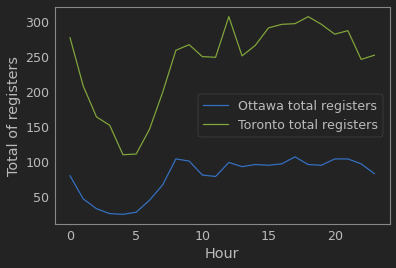

In [ ]:
slider_dict_result = {}

for iax, city in enumerate(["Ottawa", "Toronto"]):
    for i, year in enumerate(["2014", "2015", "2016", "2017", "2018", "2019"]):
        data_path = "./Data/Stolen_bikes_johan_{}.csv".format(year)
        geo_path = "./Data/Maps/pop_{}.geojson".format(city.lower())
        data, canada_map = read_data_map(data_path, geo_path, city)
#         data["year"] = year
        if i == 0: canada_data = data.copy()
        else: canada_data = canada_data.append(data) # Join all data in just one table
    
    canada_data = canada_data.groupby(["GeoUID", "Hour"]).agg(np.mean).reset_index()
    
#     display(canada_data.head().append(canada_data.tail()), canada_data.shape, canada_data.columns)
    
    slider_dict_result[city] = {}; hours_reg = []
    for h in canada_data["Hour"].sort_values().unique(): # Save each graph by hour
        data = canada_data[canada_data["Hour"] == h].copy()
        hours_reg.append(len(data))
        data = mapJoinTable(data, canada_map, how = "right", print_info = False)
        if len(data) == 0: continue # NaN hour
        fields = data.columns.drop(['GeoUID', 'Hour', 'geometry']).to_list()
        plotmap = plotMap(data, value_var = "%Theft/sqKm", caption = "%Theft/sqKm of bike by region", 
            name = 'Canada maps', fields2show = fields, zoom_start = 11, index = False)
        slider_dict_result[city][str(int(h))] = plotmap
    
    plt.plot(hours_reg, label = "{} total registers".format(city))

plt.xlabel("Hour"); plt.ylabel("Total of registers")
plt.legend(); plt.grid(); plt.show()

In [ ]:
# Plot animation of every year
def update_geomap_year(slider_dict_result):
    def interactive_anima(city, hour):
        display(slider_dict_result[city][str(hour)])
    
    # Animation controls
    anima_parameters = {
        "hour": ipywidgets.IntSlider(min=0, max=24, step=1, style = {"handle_color":"lightblue"}),
        "city": ipywidgets.Dropdown(options = ["Toronto", "Ottawa"], value = 'Toronto', description = 'City', visible = True)
    }
    
    # Front - end
    widget = ipywidgets.interactive_output(interactive_anima, anima_parameters)
    controls = ipywidgets.HBox(list(anima_parameters.values()), layout = ipywidgets.Layout(flex_flow = 'row wrap'))
    return ipywidgets.VBox([controls, widget])

update_geomap_year(slider_dict_result)

By the 17th hour, through the years, we see that the city of Ottawa has a higher density of robberies tending again to the outskirts of the city. With this information, we could start the corresponding investigations to find out the cause of this. Possibly it is easier for bicycle thieves to steal at these extremes, or it may be due to a socio-economic factor.

On the other hand, the density of robberies per area is a little more uniform in the city of Toronto, compared to the city of Ottawa. Despite the lack of information in this city, we can observe certain patterns of behavior over the years as groups of regions with high rates of theft in the center and north-center of the city.

By comparing the two cities we can ensure that there is more confidence in the data for the city of Toronto (as we have more information for this city). Additionally, a factor to consider is the maximum density value between the two cities. For the city of Ottawa, we have a percentage of 10% stolen cycles per km$^2$, in contrast to the city of Toronto with a percentage of 20% (double), which indicates that of each cycle stolen in Ottawa per area, two cycles are stolen in Toronto. 

## Correlation between cycle-theft and census-data

(Coming soon) ...

Index(['GeoUID', 'Occurrence_Date', 'Total_Theft_Bikes', 'Cost_of_Bike',
       'Occurrence_Year'],
      dtype='object')

Index(['GeoUID', 'Area (sq km)', 'Population ', 'Dwellings ', 'Households ',
       'v_CA16_5005: Total - Income statistics in 2015 for persons aged 15 years and over not in economic families in private households - 25% sample data',
       'v_CA16_3852: Total - Aboriginal identity for the population in private households - 25% sample data',
       'v_CA16_3999: Total - Ethnic origin for the population in private households - 25% sample data',
       'v_CA16_3438: Total - Age at immigration for the immigrant population in private households - 25% sample data',
       'v_CA16_3390: Total - Citizenship for the population in private households - 25% sample data',
       'v_CA16_5096: Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private households - 25% sample data',
       'v_CA16_5051: Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data',
       'v_CA16_5621: Total pop

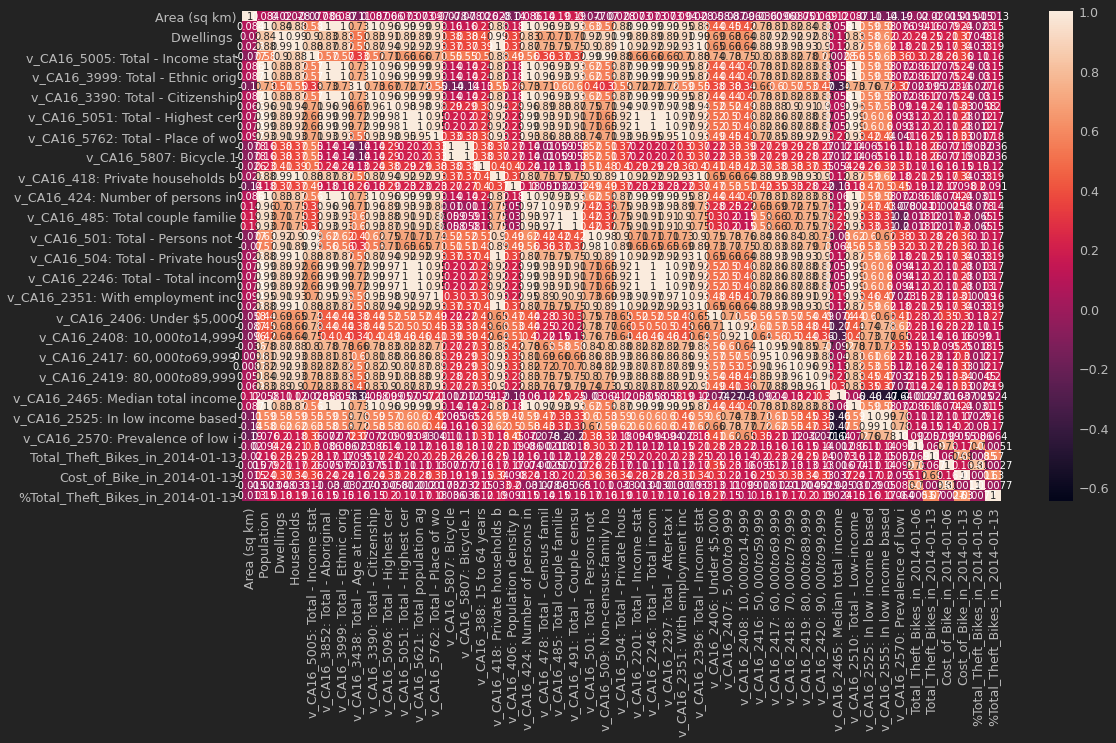

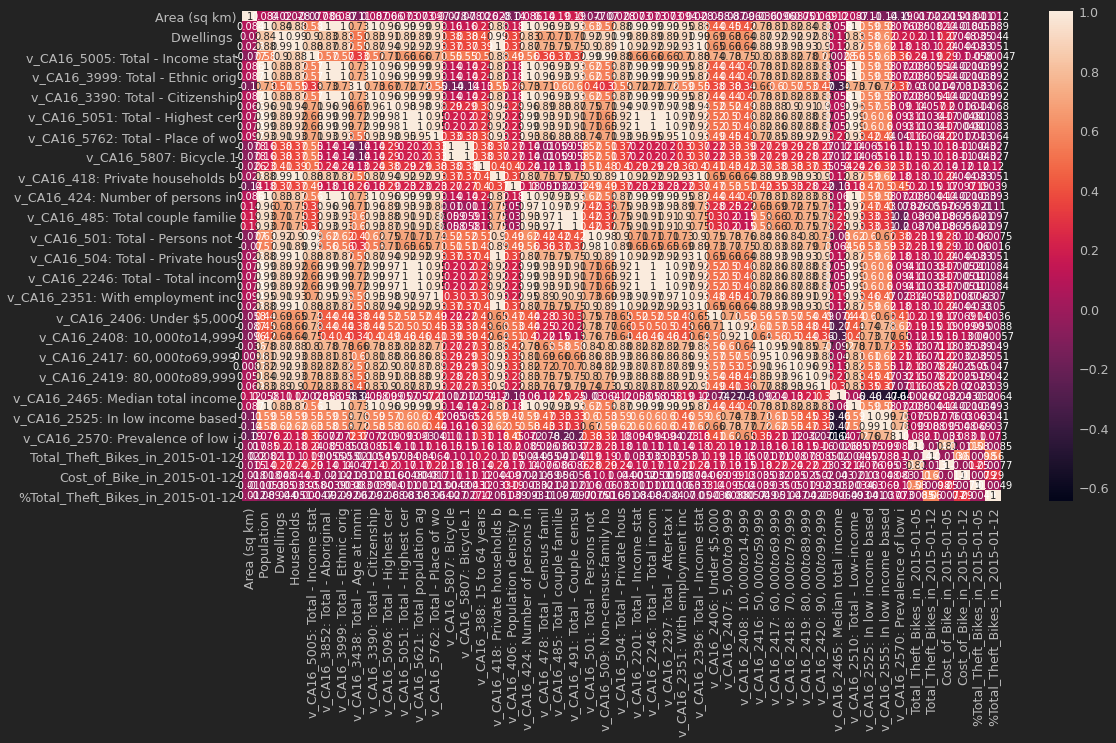

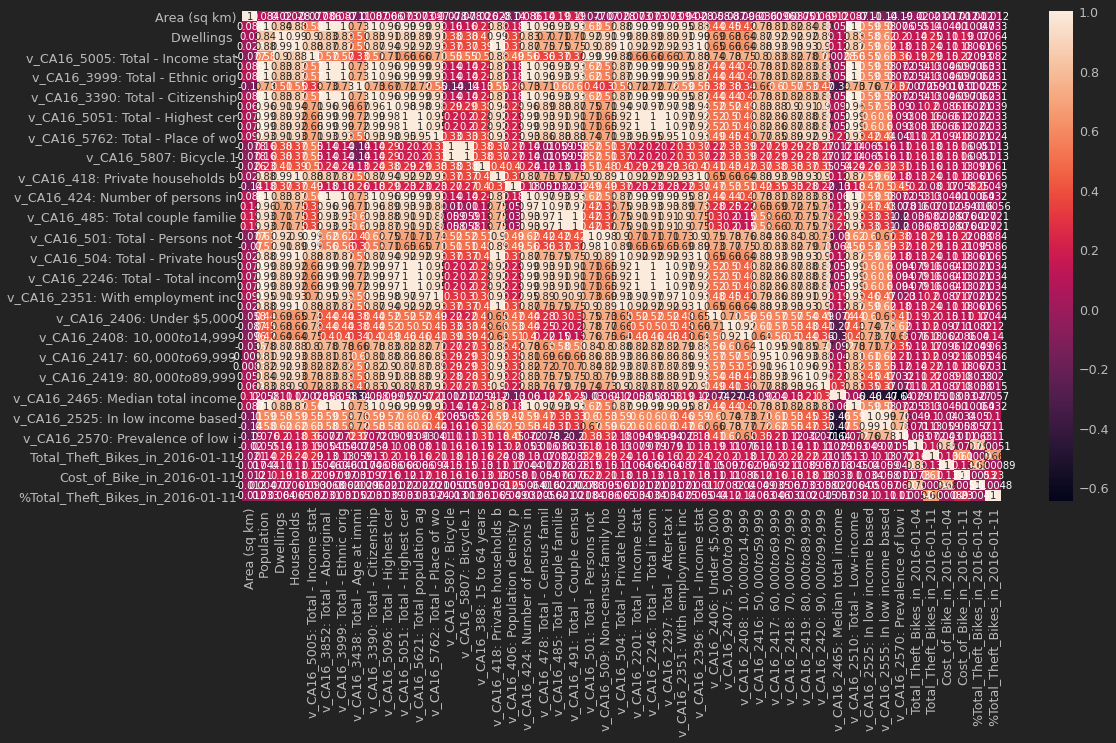

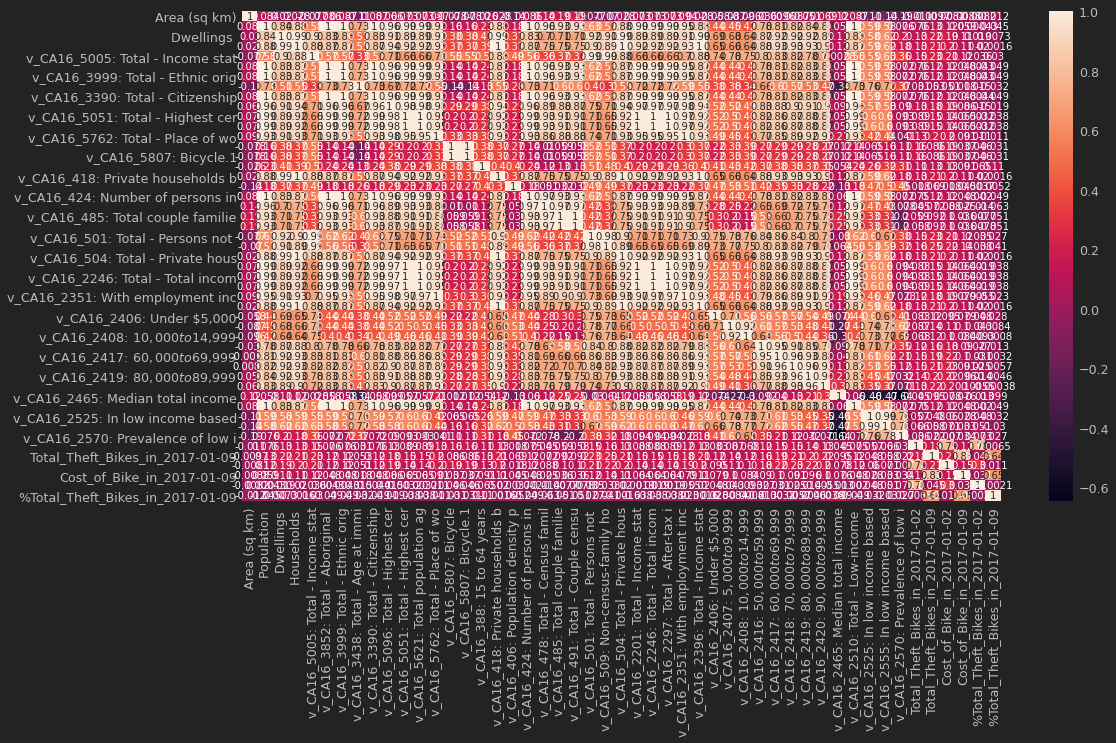

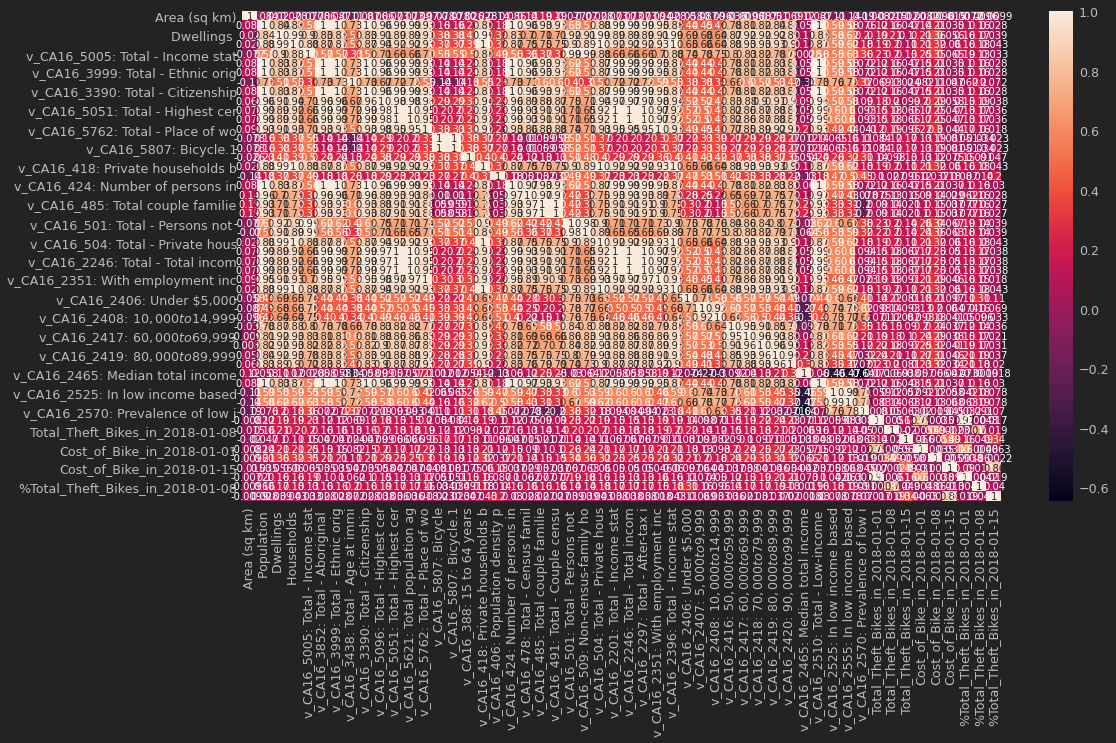

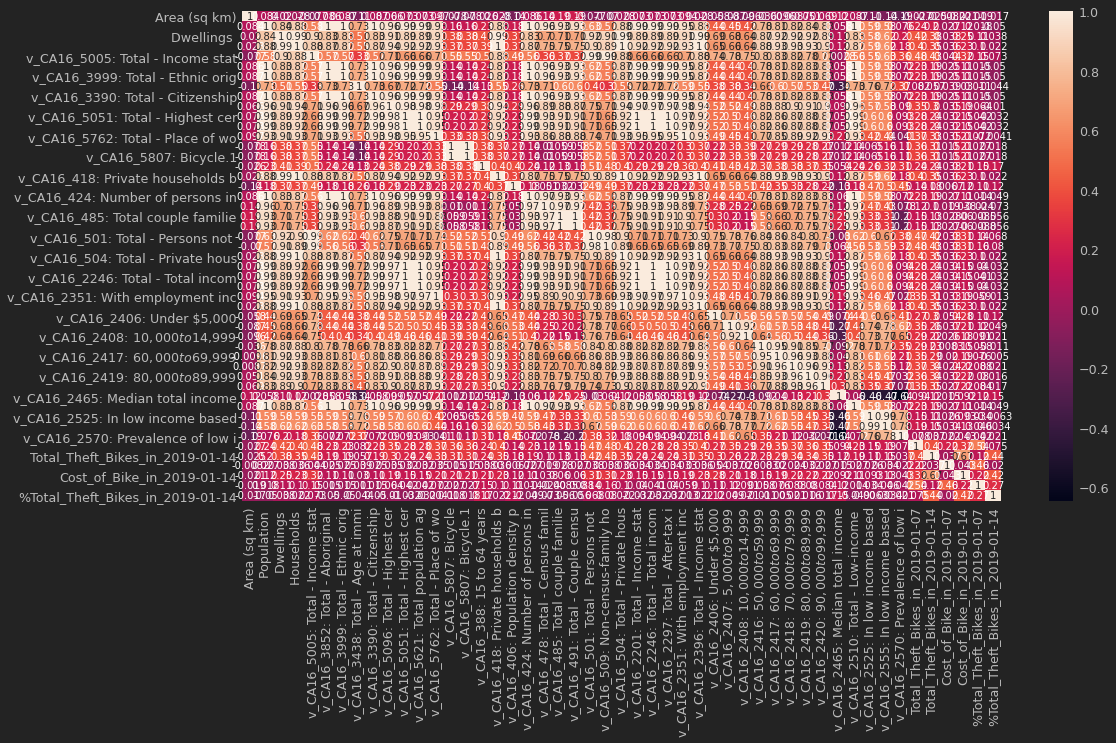

In [ ]:
def plot_corr(df):
    correlation_mat = df.corr()
    f, ax = plt.subplots(figsize=(17, 9))
    sns.heatmap(correlation_mat, annot = True)
    plt.show()

# Analysis from January 1st to "until_date" in month-day format. Columns format short or long
def fields_census_analysis(census_path, theft_path = "./Data/Bicycle_Thefts_Toronto_geo.csv", until_date = "01-15", columns_short = True): 
    # Read data and clean
    df_census = pd.read_csv(census_path, index_col = 0, dtype = {"GeoUID":str}).\
        drop(columns = ["Type", "Region Name"]).replace({"x":np.nan, "F":np.nan})
    df_census["GeoUID"] = df_census["GeoUID"].apply(lambda x: x if len(x.split(".")[-1]) > 1 else x + "0") # Fix important bug
    for col in df_census: # Type change
        df_census[col] = df_census[col].astype(float) if col != "GeoUID" else df_census[col]
    df_theft = pd.read_csv(theft_path, dtype = {"GeoUID":str})
    df_theft["GeoUID"] = df_theft["GeoUID"].apply(lambda x: x if len(x.split(".")[-1]) > 1 else x + "0") # Fix important bug

    # Data process: Get Total theft by sum registers and mean cost of bike by CT and date
    df_theft["Occurrence_Date"] = pd.to_datetime(df_theft["Occurrence_Date"])
    
    df_theft = df_theft[df_theft["Status"] == "STOLEN"].groupby(["GeoUID", pd.Grouper(key="Occurrence_Date", freq="1W-MON")]).\
        agg({"X":"count", "Cost_of_Bike":"mean", "Occurrence_Year":lambda x: x.iloc[0]}).\
        reset_index().rename(columns={"X":"Total_Theft_Bikes"}).sort_values("Occurrence_Date")

    display(df_theft.columns, df_census.columns)
    # Process by year: Split data in "date"-columns to ['Total_Theft_Bikes', 'Cost_of_Bike']
    for year in df_theft["Occurrence_Year"].unique():
        df_theft_year = df_theft[df_theft["Occurrence_Year"] == year].drop(columns = "Occurrence_Year")
        df_theft_year = df_theft_year[df_theft_year["Occurrence_Date"] <= "{}-{}".format(year, until_date)]
        df_theft_year = df_theft_year.pivot(index = 'GeoUID', columns = 'Occurrence_Date', values = ['Total_Theft_Bikes', 'Cost_of_Bike'])

        # Fix columns names
        df_theft_year = df_theft_year.T.reset_index().T
        df_theft_year.columns = df_theft_year.T["level_0"] + "_in_" + df_theft_year.T["Occurrence_Date"].astype(str) # New name
        df_theft_year = df_theft_year.drop(["level_0", "Occurrence_Date"])
        
        # Merge data with census info and corr plot
        df_census_theft = df_census.merge(df_theft_year, left_on = "GeoUID", right_index = True, how = "left").fillna(0) # NaN = 0 thefts
        for col_theft in [x for x in df_census_theft.columns if "Theft" in x]:
            df_census_theft["%{}/Area".format(col_theft)] = df_census_theft[col_theft] * 100.0
            df_census_theft["%{}/Area".format(col_theft)] /= df_census_theft['v_CA16_5807: Bicycle'] * df_census_theft['Area (sq km)']
        if columns_short:
            df_census_theft.columns = [x[:32] for x in df_census_theft.columns] # 8 characters maximum
        plot_corr(df_census_theft)

fields_census_analysis(census_path = "./census_data.csv")

## Time series

In [ ]:
def time_series_plot(census_path, theft_path = "./Data/Bicycle_Thefts_Toronto_geo.csv", year = None, threshold = None, isprint = True):
    # Read data and clean
    df_census = pd.read_csv(census_path, index_col = 0, dtype = {"GeoUID":str})
    df_census = df_census[df_census["Region Name"] == "Toronto"]
    df_census = df_census[["GeoUID", "Area (sq km)", "v_CA16_5807: Bicycle"]].replace({"x":np.nan, "F":np.nan}) # Keep important variables
    df_census["GeoUID"] = df_census["GeoUID"].apply(lambda x: x if len(x.split(".")[-1]) > 1 else x + "0") # Fix important bug
    for col in df_census: # Type change
        df_census[col] = df_census[col].astype(float) if col != "GeoUID" else df_census[col]
    df_theft = pd.read_csv(theft_path, dtype = {"GeoUID":str})
    df_theft["GeoUID"] = df_theft["GeoUID"].apply(lambda x: x if len(x.split(".")[-1]) > 1 else x + "0") # Fix important bug
    
    # Data process: Get Total theft by sum registers and mean cost of bike by CT and date
    df_theft["Occurrence_Date"] = pd.to_datetime(df_theft["Occurrence_Date"])
    df_theft = df_theft[df_theft["Status"] == "STOLEN"].groupby(["GeoUID", pd.Grouper(key="Occurrence_Date", freq="1W-MON")]).\
        agg({"X":"count", "Cost_of_Bike":"mean", "Occurrence_Year":lambda x: x.iloc[0]}).\
        reset_index().rename(columns={"X":"Total_Theft_Bikes"}).sort_values("Occurrence_Date")
    
    # Merge data with census info and corr plot
    df_theft = df_theft[df_theft["Occurrence_Year"] <= 2019]
    if isprint: display(df_theft)
    df_census_theft = df_census.merge(df_theft, on = "GeoUID", how = "right").fillna(0.0) # NaN = 0 thefts
    if isprint: display(df_census_theft[["Total_Theft_Bikes", 'v_CA16_5807: Bicycle', 'Area (sq km)']].describe())
    df_proof = df_census.loc[df_census['v_CA16_5807: Bicycle'] == 0, "GeoUID"].unique()
#     print(len(df_proof), df_proof)
    df_proof = df_census_theft.loc[df_census_theft['v_CA16_5807: Bicycle'] == 0, "GeoUID"].unique()
#     print(len(df_proof), df_proof)
    df_census_theft = df_census_theft[df_census_theft['v_CA16_5807: Bicycle'] != 0.0]
    df_census_theft["Theft_Density/Area"] = df_census_theft["Total_Theft_Bikes"] * 100.0
    df_census_theft["Theft_Density/Area"] /= df_census_theft['v_CA16_5807: Bicycle'] * df_census_theft['Area (sq km)']
    
    if isprint: display(df_census_theft["Theft_Density/Area"].describe())
    if isprint: display(df_census_theft.groupby("GeoUID").size().sort_values(ascending = False).head(30))
    
    # Plot
    fig = go.Figure()
    df_census_theft = df_census_theft.sort_values("Occurrence_Date")
    total_df = []
    if year is not None: df_census_theft = df_census_theft[df_census_theft["Occurrence_Year"] == year]
    for ct in df_census_theft["GeoUID"].unique():
        df_census_theft_ct = df_census_theft[df_census_theft["GeoUID"] == ct].set_index("Occurrence_Date")
        area = df_census_theft_ct["Area (sq km)"].iloc[0] # Store values
        bike = df_census_theft_ct["v_CA16_5807: Bicycle"].iloc[0]
        if threshold is None or len(df_census_theft_ct) > threshold:
            df_census_theft_ct = df_census_theft_ct.reindex(pd.date_range(start = '01/01/2014', end = '31/12/2019', freq = 'W-MON')).fillna(0.0)
            # Restore values
            df_census_theft_ct["GeoUID"] = ct; df_census_theft_ct.loc[:, "Area (sq km)"] = area
            df_census_theft_ct.loc[:, "v_CA16_5807: Bicycle"] = bike
            total_df.append(df_census_theft_ct.drop(columns = ["Occurrence_Year"]).reset_index().rename(columns = {"index":"Occurrence_Date"}))
            if isprint: 
                fig.add_trace(go.Scatter(x = df_census_theft_ct.index, y = df_census_theft_ct["Theft_Density/Area"], 
                                         mode = 'lines', name = 'CT-' + ct))
    if isprint: 
        fig.update_xaxes(visible = False)
        fig.update_yaxes(title = "%Vol de vélo/Area")
        fig.show()
    result = pd.concat(total_df, ignore_index = True)
    print(result['GeoUID'].unique())
    return result

time_series_plot(census_path = "./Data/census_data.csv", year = None, threshold = 100)

GeoUID Occurrence_Date  ...  Cost_of_Bike  Occurrence_Year
6316   5350063.04      2014-01-06  ...        1800.0             2014
10604  5350195.02      2014-01-06  ...         900.0             2014
10082  5350165.00      2014-01-06  ...         560.0             2014
809    5350011.00      2014-01-06  ...        1019.0             2014
6748   5350066.00      2014-01-06  ...           0.0             2014
...           ...             ...  ...           ...              ...
374    5350008.01      2019-12-30  ...         850.0             2019
7545   5350081.00      2020-01-06  ...        2200.0             2019
5742   5350060.00      2020-01-06  ...        1000.0             2019
2013   5350015.00      2020-01-06  ...           NaN             2019
4274   5350039.00      2020-01-06  ...        4000.0             2019

[13540 rows x 5 columns]

Total_Theft_Bikes  v_CA16_5807: Bicycle  Area (sq km)
count       13540.000000          13540.000000  13540.000000
mean            1.544535            157.756647      0.847719
std             1.112949            150.793402      1.240024
min             1.000000              0.000000      0.075010
25%             1.000000             30.000000      0.368730
50%             1.000000            115.000000      0.547350
75%             2.000000            245.000000      0.914210
max            17.000000            740.000000     20.224900

count    12815.000000
mean         5.975244
std         12.232905
min          0.135916
25%          1.000350
50%          2.181415
75%          6.143204
max        193.854803
Name: Theft_Density/Area, dtype: float64

GeoUID
5350035.00    257
5350011.00    243
5350062.02    197
5350016.00    197
5350014.00    190
5350034.02    186
5350037.00    165
5350010.02    164
5350008.02    161
5350061.00    160
5350012.01    156
5350062.01    147
5350017.00    143
5350044.00    141
5350012.03    138
5350032.00    128
5350066.00    126
5350038.00    126
5350015.00    124
5350012.04    124
5350092.00    120
5350013.01    119
5350091.01    118
5350013.02    111
5350064.00    104
5350008.01    102
5350089.00    101
5350063.05    100
5350060.00     99
5350063.06     99
dtype: int64

['5350062.02' '5350011.00' '5350066.00' '5350012.04' '5350012.01'
 '5350016.00' '5350014.00' '5350032.00' '5350037.00' '5350017.00'
 '5350062.01' '5350010.02' '5350092.00' '5350008.01' '5350034.02'
 '5350091.01' '5350035.00' '5350089.00' '5350038.00' '5350044.00'
 '5350013.01' '5350012.03' '5350064.00' '5350013.02' '5350061.00'
 '5350015.00' '5350008.02']


Occurrence_Date      GeoUID  ...  Cost_of_Bike  Theft_Density/Area
0         2014-01-06  5350062.02  ...       1750.00            1.627056
1         2014-01-13  5350062.02  ...          0.00            0.000000
2         2014-01-20  5350062.02  ...       1400.00            1.627056
3         2014-01-27  5350062.02  ...          0.00            0.000000
4         2014-02-03  5350062.02  ...          0.00            0.000000
...              ...         ...  ...           ...                 ...
8446      2019-12-02  5350008.02  ...       1250.00            0.271832
8447      2019-12-09  5350008.02  ...          0.00            0.000000
8448      2019-12-16  5350008.02  ...          0.00            0.000000
8449      2019-12-23  5350008.02  ...         37.50            0.271832
8450      2019-12-30  5350008.02  ...        734.49            0.135916

[8451 rows x 7 columns]

## Time series and census data join

Index(['GeoUID', 'Type', 'Region Name', 'Area (sq km)', 'Population ',
       'Dwellings ', 'Households ',
       'v_CA16_5005: Total - Income statistics in 2015 for persons aged 15 years and over not in economic families in private households - 25% sample data',
       'v_CA16_3852: Total - Aboriginal identity for the population in private households - 25% sample data',
       'v_CA16_3999: Total - Ethnic origin for the population in private households - 25% sample data',
       'v_CA16_3438: Total - Age at immigration for the immigrant population in private households - 25% sample data',
       'v_CA16_3390: Total - Citizenship for the population in private households - 25% sample data',
       'v_CA16_5096: Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private households - 25% sample data',
       'v_CA16_5051: Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data',


Density_Theft_Bikes_in_2014-04-14/Area  \
13                                0.226672   

    Density_Theft_Bikes_in_2014-04-21/Area  \
13                                0.226672   

    Density_Theft_Bikes_in_2014-04-28/Area  \
13                                     0.0   

    Density_Theft_Bikes_in_2014-05-05/Area  \
13                                     0.0   

    Density_Theft_Bikes_in_2014-05-12/Area  
13                                0.226672

Density_Theft_Bikes_in_2014-04-14/Area  \
42                                6.287125   

    Density_Theft_Bikes_in_2014-04-21/Area  \
42                                 2.51485   

    Density_Theft_Bikes_in_2014-04-28/Area  \
42                                 2.51485   

    Density_Theft_Bikes_in_2014-05-05/Area  \
42                                1.257425   

    Density_Theft_Bikes_in_2014-05-12/Area  
42                               13.831676

Density_Theft_Bikes_in_2014-04-14/Area  \
19                               21.156857   

    Density_Theft_Bikes_in_2014-04-21/Area  \
19                               21.156857   

    Density_Theft_Bikes_in_2014-04-28/Area  \
19                                     0.0   

    Density_Theft_Bikes_in_2014-05-05/Area  \
19                                     0.0   

    Density_Theft_Bikes_in_2014-05-12/Area  
19                               42.313714

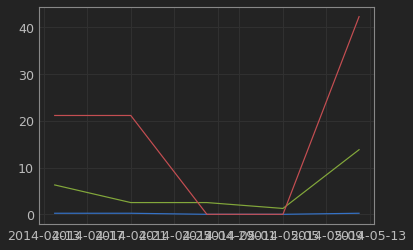

In [ ]:
def time_series_census_join(census_path, theft_path = "./Data/Bicycle_Thefts_Toronto_geo.csv", start_date = None, end_date = None):
    # Read data and clean
    df_census = pd.read_csv(census_path, index_col = 0, dtype = {"GeoUID":str})
    df_census = df_census[df_census["Region Name"] == "Toronto"].replace({"x":np.nan, "F":np.nan}) # Keep important variables
    df_census["GeoUID"] = df_census["GeoUID"].apply(lambda x: x if len(x.split(".")[-1]) > 1 else x + "0") # Fix important bug
    for col in df_census: # Type change
        df_census[col] = df_census[col].astype(float) if col not in ["GeoUID","Type","Region Name"] else df_census[col]
    df_theft = pd.read_csv(theft_path, dtype = {"GeoUID":str})
    df_theft["GeoUID"] = df_theft["GeoUID"].apply(lambda x: x if len(x.split(".")[-1]) > 1 else x + "0") # Fix important bug 
    
    ## Data process:
    # Get Total theft by sum registers and mean cost of bike by CT and date
    df_theft["Occurrence_Date"] = pd.to_datetime(df_theft["Occurrence_Date"])
    
    # Group info
    df_theft = df_theft[df_theft["Status"] == "STOLEN"].groupby(["GeoUID", pd.Grouper(key="Occurrence_Date", freq="1W-MON")]).\
        agg({"X":"count", "Cost_of_Bike":"mean", "Occurrence_Year": lambda x: x.iloc[0]}).\
        reset_index().rename(columns={"X":"Total_Theft_Bikes"}).sort_values("Occurrence_Date")
    
    # Keep important data
    if start_date is not None: df_theft = df_theft[df_theft["Occurrence_Date"] >= start_date] 
    if end_date is not None: df_theft = df_theft[df_theft["Occurrence_Date"] <= end_date]
    
    # Get individual week data by week-columns
    df_theft = df_theft.pivot(index = 'GeoUID', columns = 'Occurrence_Date', values = ['Total_Theft_Bikes', 'Cost_of_Bike'])
    df_theft = df_theft.T.reset_index().T
    df_theft.columns = df_theft.T["level_0"] + "_in_" + df_theft.T["Occurrence_Date"].astype(str) # New name
    df_theft = df_theft.drop(["level_0", "Occurrence_Date"])
    
    # Merge data
    df_census_theft = (df_census.merge(df_theft, on = "GeoUID", how = "left")
                       .dropna(subset=['v_CA16_5807: Bicycle', 'Area (sq km)'])).fillna(0)
    
    # Density estimation in all Total_Theft_Bikes columns
    for col_theft in [x for x in df_census_theft.columns if "Total_Theft_Bikes" in x]:
        aux_name = "Density_{}/Area".format(col_theft.replace("Total_",""))
        df_census_theft[aux_name] = df_census_theft[col_theft] * 100.0
        df_census_theft[aux_name] /= df_census_theft['v_CA16_5807: Bicycle'] * df_census_theft['Area (sq km)']

    return df_census_theft

df = time_series_census_join(census_path = "./Data/census_data.csv", start_date = '14-04-2014', end_date = '14-05-2014')
display(df.columns)
for geo in ["5350011.00", "5350035.00", "5350014.00"]:
    x = pd.date_range(start = '14/04/2014', end = '14/05/2014', freq = '1W-MON')
    y = df.loc[df["GeoUID"] == geo, [x for x in df.columns if "Density" in x]]
    display(y)
    plt.plot(x,y.to_numpy().squeeze(),label = geo)

plt.plot()

# Save full census
df.to_csv("./Data/census_theft_data.csv", index = False)

In [ ]:
df.dropna()

GeoUID Type Region Name  Area (sq km)  Population   Dwellings   \
0    5350001.00   CT     Toronto       6.62211        595.0       274.0   
1    5350002.00   CT     Toronto       3.29470        620.0       279.0   
2    5350003.00   CT     Toronto       0.94253        749.0       267.0   
3    5350004.00   CT     Toronto       0.34347       6686.0      3609.0   
4    5350005.00   CT     Toronto       0.37612       6424.0      3729.0   
..          ...  ...         ...           ...          ...         ...   
563  5350378.22   CT     Toronto       0.53214       3454.0       891.0   
564  5350378.23   CT     Toronto       1.53025       4095.0      1334.0   
565  5350378.24   CT     Toronto       2.52877       6109.0      2218.0   
566  5350378.25   CT     Toronto       4.76673       7931.0      1885.0   
567  5350378.26   CT     Toronto       1.66052       4761.0      1165.0   

     Households   \
0          247.0   
1          270.0   
2          258.0   
3         3455.0   
4         3424.0   
..           ...   
563        877.0   
564       1302.0   
565       2147.0   
566       1858.0   
567       1144.0   

     v_CA16_5005: Total - Income statistics in 2015 for persons aged 15 years and over not in economic families in private households - 25% sample data  \
0                                                120.0                                                                                                    
1                                                100.0                                                                                                    
2                                                150.0                                                                                                    
3                                               2565.0                                                                                                    
4                                               2380.0                                                                                                    
..                                                 ...                                                                                                    
563                                              295.0                                                                                                    
564                                              460.0                                                                                                    
565                                              680.0                                                                                                    
566                                              240.0                                                                                                    
567                                              100.0                                                                                                    

     v_CA16_3852: Total - Aboriginal identity for the population in private households - 25% sample data  \
0                                                575.0                                                     
1                                                655.0                                                     
2                                                455.0                                                     
3                                               6350.0                                                     
4                                               6105.0                                                     
..                                                 ...                                                     
563                                             3380.0                                                     
564                                             4025.0                                                     
565                               

## Minibatch time series

In [ ]:
def load_database(census_path = "./Data/census_data.csv", theft_path = "./Data/Bicycle_Thefts_Toronto_geo.csv", 
                  threshold = 100, CTs = [], start_date = None, end_date = None, tscol = 'Theft_Density/Area', 
                  ini_states = [], step_past = 1, step_future = 1):
    # Merge data and filter it by dates and CTs
    time_series = time_series_plot(census_path = census_path, theft_path = theft_path, threshold = threshold, isprint = False)
    # Keep important data by date
    init_values = [] # Save initial states
    for ini_val in ini_states: init_values.append(time_series[time_series["Occurrence_Date"] == ini_val])
    if len(init_values) > 0: 
        init_values = pd.concat(init_values, ignore_index = True)
        init_values = init_values.sort_values("Occurrence_Date")
    if start_date is not None: time_series = time_series[time_series["Occurrence_Date"] >= start_date] 
    if end_date is not None: time_series = time_series[time_series["Occurrence_Date"] <= end_date]
    # Keep important data by CT 
    time_series_filter = []
    for ct in CTs:
        time_series_filter.append(time_series[time_series["GeoUID"] == ct])
    if len(time_series_filter) > 0: time_series = pd.concat(time_series_filter, ignore_index = True)
    display(time_series, time_series.shape)
    
    # Process: data organize by batches: (i0,i1,i2,i3, x0,x1,x2,x3, x4)
    time_series = time_series.sort_values("Occurrence_Date")
    total_batches = None
    for ct in time_series["GeoUID"].unique():
        CT_time_series = time_series.loc[time_series["GeoUID"] == ct, tscol].to_numpy()
        if len(init_values) > 0: CT_init_values = init_values.loc[init_values["GeoUID"] == ct, tscol].to_numpy()
        N = len(CT_time_series) - (step_past + step_future) + 1
        # Get matrix window-slider
        CT_time_series = CT_time_series[np.arange(N)[None, :] + np.arange(step_past + step_future)[:, None]].T
        if len(init_values) > 0: # Add initial values
            CT_init_values = np.ones((len(CT_time_series),1)) * CT_init_values[None]
            CT_time_series = np.append(CT_init_values, CT_time_series, axis = 1)
        if total_batches is None: total_batches = CT_time_series # Join all data
        else: total_batches = np.append(total_batches, CT_time_series, axis = 1)
    return total_batches

In [ ]:
## User parameters
CTs = ["5350035.00"] # CT list to filter in data
set_dates = {"train": ('14-04-2014', '31-12-2018'), # Start/End date for each dataset
             "valid": ('01-01-2019', '30-06-2019'), "test": ('01-07-2019', '31-12-2019')}
ini_states = ["2014-04-14", "2014-04-21","2014-04-28","2014-05-05","2014-05-12"] # Initial states
step_past = len(ini_states) # Past values in order to predict ...
step_future = 1 # Future steps
batch_size = 128

## Datasets creation
batch_datasets = {key: load_database(threshold = 150, CTs = CTs, start_date = dates[0], end_date = dates[1],
                                     ini_states = ini_states, step_past = step_past, step_future = step_future) 
                  for key, dates in set_dates.items()}
batch_datasets = {key: torch.from_numpy(value).float() for key, value in batch_datasets.items()}
dataloaders = {key: DataLoader(value, batch_size = batch_size, shuffle = True) for key, value in batch_datasets.items()}
datasets_sizes = {key: len(value) for key, value in batch_datasets.items()}
print(datasets_sizes)

Occurrence_Date      GeoUID  Area (sq km)  v_CA16_5807: Bicycle  \
0        2014-04-14  5350035.00       0.66273                 120.0   
1        2014-04-21  5350035.00       0.66273                 120.0   
2        2014-04-28  5350035.00       0.66273                 120.0   
3        2014-05-05  5350035.00       0.66273                 120.0   
4        2014-05-12  5350035.00       0.66273                 120.0   
..              ...         ...           ...                   ...   
242      2018-12-03  5350035.00       0.66273                 120.0   
243      2018-12-10  5350035.00       0.66273                 120.0   
244      2018-12-17  5350035.00       0.66273                 120.0   
245      2018-12-24  5350035.00       0.66273                 120.0   
246      2018-12-31  5350035.00       0.66273                 120.0   

     Total_Theft_Bikes  Cost_of_Bike  Theft_Density/Area  
0                  5.0         770.0            6.287125  
1                  2.0         900.0            2.514850  
2                  2.0         350.0            2.514850  
3                  1.0         900.0            1.257425  
4                 11.0         779.5           13.831676  
..                 ...           ...                 ...  
242                3.0         750.0            3.772275  
243                0.0           0.0            0.000000  
244                1.0         350.0            1.257425  
245                2.0        1025.0            2.514850  
246                1.0        1433.0            1.257425  

[247 rows x 7 columns]

(247, 7)

Occurrence_Date      GeoUID  Area (sq km)  v_CA16_5807: Bicycle  \
0       2019-01-07  5350035.00       0.66273                 120.0   
1       2019-01-14  5350035.00       0.66273                 120.0   
2       2019-01-21  5350035.00       0.66273                 120.0   
3       2019-01-28  5350035.00       0.66273                 120.0   
4       2019-02-04  5350035.00       0.66273                 120.0   
5       2019-02-11  5350035.00       0.66273                 120.0   
6       2019-02-18  5350035.00       0.66273                 120.0   
7       2019-02-25  5350035.00       0.66273                 120.0   
8       2019-03-04  5350035.00       0.66273                 120.0   
9       2019-03-11  5350035.00       0.66273                 120.0   
10      2019-03-18  5350035.00       0.66273                 120.0   
11      2019-03-25  5350035.00       0.66273                 120.0   
12      2019-04-01  5350035.00       0.66273                 120.0   
13      2019-04-08  5350035.00       0.66273                 120.0   
14      2019-04-15  5350035.00       0.66273                 120.0   
15      2019-04-22  5350035.00       0.66273                 120.0   
16      2019-04-29  5350035.00       0.66273                 120.0   
17      2019-05-06  5350035.00       0.66273                 120.0   
18      2019-05-13  5350035.00       0.66273                 120.0   
19      2019-05-20  5350035.00       0.66273                 120.0   
20      2019-05-27  5350035.00       0.66273                 120.0   
21      2019-06-03  5350035.00       0.66273                 120.0   
22      2019-06-10  5350035.00       0.66273                 120.0   
23      2019-06-17  5350035.00       0.66273                 120.0   
24      2019-06-24  5350035.00       0.66273                 120.0   

    Total_Theft_Bikes  Cost_of_Bike  Theft_Density/Area  
0                 1.0   2000.000000            1.257425  
1                 1.0   4000.000000            1.257425  
2                 2.0    385.000000            2.514850  
3                 1.0   2100.000000            1.257425  
4                 0.0      0.000000            0.000000  
5                 0.0      0.000000            0.000000  
6                 1.0    350.000000            1.257425  
7                 2.0    800.000000            2.514850  
8                 0.0      0.000000            0.000000  
9                 1.0    175.000000            1.257425  
10                1.0    800.000000            1.257425  
11                1.0    500.000000            1.257425  
12                0.0      0.000000            0.000000  
13                0.0      0.000000            0.000000  
14                1.0    625.000000            1.257425  
15                4.0    350.000000            5.029700  
16                5.0    271.994000            6.287125  
17                2.0    437.500000            2.514850  
18                3.0    316.666667            3.772275  
19                6.0    831.800000            7.544551  
20                6.0   1565.481667            7.544551  
21                3.0    493.333333            3.772275  
22                2.0   1050.000000            2.514850  
23                2.0   1500.000000            2.514850  
24                7.0    481.833333            8.801976

(25, 7)

Occurrence_Date      GeoUID  Area (sq km)  v_CA16_5807: Bicycle  \
0       2019-01-07  5350035.00       0.66273                 120.0   
1       2019-01-14  5350035.00       0.66273                 120.0   
2       2019-01-21  5350035.00       0.66273                 120.0   
3       2019-01-28  5350035.00       0.66273                 120.0   
4       2019-02-04  5350035.00       0.66273                 120.0   
5       2019-02-11  5350035.00       0.66273                 120.0   
6       2019-02-18  5350035.00       0.66273                 120.0   
7       2019-02-25  5350035.00       0.66273                 120.0   
8       2019-03-04  5350035.00       0.66273                 120.0   
9       2019-03-11  5350035.00       0.66273                 120.0   
10      2019-03-18  5350035.00       0.66273                 120.0   
11      2019-03-25  5350035.00       0.66273                 120.0   
12      2019-04-01  5350035.00       0.66273                 120.0   
13      2019-04-08  5350035.00       0.66273                 120.0   
14      2019-04-15  5350035.00       0.66273                 120.0   
15      2019-04-22  5350035.00       0.66273                 120.0   
16      2019-04-29  5350035.00       0.66273                 120.0   
17      2019-05-06  5350035.00       0.66273                 120.0   
18      2019-05-13  5350035.00       0.66273                 120.0   
19      2019-05-20  5350035.00       0.66273                 120.0   
20      2019-05-27  5350035.00       0.66273                 120.0   
21      2019-06-03  5350035.00       0.66273                 120.0   
22      2019-06-10  5350035.00       0.66273                 120.0   
23      2019-06-17  5350035.00       0.66273                 120.0   
24      2019-06-24  5350035.00       0.66273                 120.0   
25      2019-07-01  5350035.00       0.66273                 120.0   
26      2019-07-08  5350035.00       0.66273                 120.0   
27      2019-07-15  5350035.00       0.66273                 120.0   
28      2019-07-22  5350035.00       0.66273                 120.0   
29      2019-07-29  5350035.00       0.66273                 120.0   
30      2019-08-05  5350035.00       0.66273                 120.0   
31      2019-08-12  5350035.00       0.66273                 120.0   
32      2019-08-19  5350035.00       0.66273                 120.0   
33      2019-08-26  5350035.00       0.66273                 120.0   
34      2019-09-02  5350035.00       0.66273                 120.0   
35      2019-09-09  5350035.00       0.66273                 120.0   
36      2019-09-16  5350035.00       0.66273                 120.0   
37      2019-09-23  5350035.00       0.66273                 120.0   
38      2019-09-30  5350035.00       0.66273                 120.0   
39      2019-10-07  5350035.00       0.66273                 120.0   
40      2019-10-14  5350035.00       0.66273                 120.0   
41      2019-10-21  5350035.00       0.66273                 120.0   
42      2019-10-28  5350035.00       0.66273                 120.0   
43      2019-11-04  5350035.00       0.66273                 120.0   
44      2019-11-11  5350035.00       0.66273                 120.0   
45      2019-11-18  5350035.00       0.66273                 120.0   
46      2019-11-25  5350035.00       0.66273                 120.0   
47      2019-12-02  5350035.00       0.66273                 120.0   
48      2019-12-09  5350035.00       0.66273                 120.0   
49      2019-12-16  5350035.00       0.66273                 120.0   
50      2019-12-23  5350035.00       0.66273                 120.0   
51      2019-12-30  5350035.00       0.66273                 120.0   

    Total_Theft_Bikes  Cost_of_Bike  Theft_Density/Area  
0                 1.0   2000.000000            1.257425  
1                 1.0   4000.000000            1.257425  
2                 2.0    385.000000            2.514850  
3                 1.0   2100.000000            1.257425  
4 

(52, 7)

{'train': 242, 'valid': 20, 'test': 47}
